<a href="https://colab.research.google.com/github/amir8099/Repository-example/blob/master/Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#                                      CAPSTONE PROJECT: Battle of Neighborhoods
##            **FINDING A LOCATION IN SAN DIEGO TO OPEN A COFFEE SHOP**
### By: Amir Asadi


#### **1. OVERVIEW AND OBJECTIVES**
 The **main goal** of this project is to find the best location to open a new coffee shop in the city of San Diego. San Diego has an estimated population of 1,423,851 as of July 1, 2017 (United States Census Bureau).  By 2030, the City's population is forecast to be 1.69 million. With its pleasant climate and a growing sector focused on arts and culture, San Diego is one of top visitor and convention destinations  in the world attracting more than 35 million tourists each year. It is predicted that the number of visitors to San Diego will grow roughly 2% each year for the next five years, and their spending will grow 3.9% each year (see San Diego Tourism Authority, 2019). Therefore, it is doomed that bars, restaurants and coffee shops will constantly grow. The **specific objective** of this project ts to answer this question: "Where should one open a new coffee shop in San Diego considering the number and rating of the coffee shops in the intended area?" _Note_ that this project will offer the potential locations without considering the associated costs such as real estate, development, etc. 

#### **2. DATA**
To meet the objective, we need the data containing neighborhoods, boroughs and their geographical locations in Sad Diego. These data will be obtained from the following source.
  https://data.sandiego.gov/datasets/pd-neighborhoods/

Data related to locations and ratings of of coffee shops in San Diego will be acquired via the FourSquare API utilized via the Request library in Python.


#### **3. METGODOLOGY**
1. The data from https://data.sandiego.gov/datasets/pd-neighborhoods/ (nested Python dictionary) will be cleaned and transformed to a pandas dataframe. 
2. We will utalize Foursquare API to explore the neighborhoods and segment them, obtain their latitude and longitude values, locate all nearby venues, to filter coffee shops, and extract their ratings. These rating will be stored into the dataframe created in step 1.
3. The neighborhoods will be clustered by KMeans method.
4. We will examine the clusters to distinguish each cluster by the coffee shops ratings.
5. The data will be visualized using Python libraries.

#### **4. OBTAINING REQUIRED DATA**
***4.1 Import Libraries needed for the project***

In [6]:
import pandas as pd
import numpy as np
import requests
import json
from pandas.io.json import json_normalize
!conda install -c conda-forge folium=0.5.0 --yes
import folium 
!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline
import seaborn as sns
from sklearn.cluster import KMeans
! pip install tabula-py
import tabula
!conda install -c conda-forge bs4 --yes
from bs4 import BeautifulSoup
!pip install lxml
print('Libraries imported.')

/bin/bash: conda: command not found
/bin/bash: conda: command not found
/bin/bash: conda: command not found
Libraries imported.


***4.2 Load and Explore San Diego Data***

In [7]:
# Reading zipcodes and corresponding neighborhoods from a PDF file using tabule.read_pdf
source="http://www.sdcourt.ca.gov/pls/portal/docs/PAGE/SDCOURT/GENERALINFORMATION/FORMS/ADMINFORMS/ADM254.PDF"
SD_list=tabula.convert_into(source, "SD_zipcodes.csv")
SD_zipcode2=pd.read_csv('SD_zipcodes.csv')
SD_zipcode2.head()

'pages' argument isn't specified.Will extract only from page 1 by default.


,ZIP CODE,Unnamed: 1,CITY NAME,DIVISION,ZIP CODE.1,Unnamed: 5,CITY NAME.1,DIVISION.1,ZIP CODE.2,Unnamed: 9,CITY NAME.2,DIVISION.2
0,91901,NaN,ALPINE,EAST,92037,NaN,LA JOLLA,CENTRAL,92123.0,NaN,"SD, SERRA MESA",CENTRAL
1,91902,NaN,BONITA,SOUTH,92038,NaN,LA JOLLA (POB),CENTRAL,92124.0,NaN,"SD, TIERRASANTA",CENTRAL
2,91903,NaN,ALPINE (POB),EAST,92039,NaN,LA JOLLA (POB),CENTRAL,92126.0,NaN,"SD, MIRA MESA",CENTRAL
3,91905,NaN,BOULEVARD,EAST,92040,NaN,LAKESIDE,EAST,92127.0,NaN,"SD, RANCHO BERNARDO",CENTRAL
4,91906,NaN,CAMPO,EAST,92046,NaN,ESCONDIDO (POB),NORTH,92128.0,NaN,"SD, RANCHO BERNARDO",CENTRAL


In [8]:
SD_df= pd.read_csv('SD_zipcodes_neighborhoods.csv')
del SD_df['Unnamed: 1']
#SD_df.drop(columns=['Unnamed: 1'])
SD_df.head()

,ZIP CODE,CITY NAME,DIVISION
0,91901,ALPINE,EAST
1,91902,BONITA,SOUTH
2,91903,ALPINE (POB),EAST
3,91905,BOULEVARD,EAST
4,91906,CAMPO,EAST


***4.3 Cleaning data and addingg Longitude and Latitude to the data frame***

In [9]:
latitude=[] #List to collect the latitudes
longitude=[] #List to collect the longitudes
US_zip_df=pd.read_csv('US Zip Codes from 2013 Government Data.csv')
US_zip_df.columns=['ZIP CODE', 'Latitude', 'Longitude']
SD_df.columns=['ZIP CODE', 'Neighborhood', 'Location']

SD_df_final=pd.merge(SD_df, US_zip_df, on='ZIP CODE')

SD_df_final.head()

,ZIP CODE,Neighborhood,Location,Latitude,Longitude
0,91901,ALPINE,EAST,32.808563,-116.710076
1,91902,BONITA,SOUTH,32.665762,-117.018657
2,91905,BOULEVARD,EAST,32.678070,-116.306851
3,91906,CAMPO,EAST,32.654821,-116.465541
4,91910,CHULA VISTA,SOUTH,32.637868,-117.058031


_Number of Neighborhods and Locations in San Diego_

In [10]:
Location_No=len(SD_df_final['Location'].unique())
Neighborhood_No=len(SD_df_final['Neighborhood'].unique())
print('San Diego has {} boroughs and {} neighborhoods.'.format(Location_No,Neighborhood_No))


San Diego has 4 boroughs and 87 neighborhoods.


From a simple search, the longitude and latitude of Sad Diego is 32.7157° N, 117.1611° W. We use thes to creat the map of San Diego. We can also use geolocator to find it as below.

In [11]:
address = 'San Diego, CA'

geolocator = Nominatim()
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of neighborhood_1 are {}, {}.'.format(latitude, longitude))

/usr/local/lib/python3.6/dist-packages/geopy/geocoders/osm.py:143: UserWarning: Using Nominatim with the default "geopy/1.17.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  UserWarning


The geograpical coordinate of neighborhood_1 are 32.7174209, -117.1627714.


In [12]:
# create map of San Diego using latitude and longitude values
latitude=32.7157
longitude=-117.1611
map_SD = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, loc, nei in zip(SD_df_final['Latitude'], SD_df_final['Longitude'], SD_df_final['Location'], SD_df_final['Neighborhood']):
    label = '{}, {}'.format(nei, loc)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_SD)  
    
map_SD

Let's define FourSquare Credentials

In [13]:
CLIENT_ID = 'GTPZYIIDA0GYHYRBYHRZAFCA4QT4WA2G5XDLLEHKMLCR5IIU' 
CLIENT_SECRET = '0RLXRR1TZBBSHTLD0A2AXWNRDXBWSJQPHR3QNOPNQ2HCU54W' 
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: GTPZYIIDA0GYHYRBYHRZAFCA4QT4WA2G5XDLLEHKMLCR5IIU
CLIENT_SECRET:0RLXRR1TZBBSHTLD0A2AXWNRDXBWSJQPHR3QNOPNQ2HCU54W


Let's explore all neighborhoods in San Diegoo

In [14]:
# A function to find venues nearby using FourSquare 
LIMIT = 100 # limit of number of venues returned by Foursquare API

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
           
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']                                    
                      
    return(nearby_venues)


In [15]:
 SD_venues = getNearbyVenues(names=SD_df_final['Neighborhood'],
                                   latitudes=SD_df_final['Latitude'],
                                   longitudes=SD_df_final['Longitude']
                                  )

ALPINE
BONITA
BOULEVARD
CAMPO
CHULA VISTA
CHULA VISTA
CHULA VISTA
CHULA VISTA
CHULA VISTA
DESCANSO
DULZURA
GUATAY (POB)
IMPERIAL BEACH
JACUMBA
JAMUL
LA MESA
LA MESA
LEMON GROVE
MOUNT LAGUNA (POB)
NATIONAL CITY
PINE VALLEY
POTRERO
SPRING VALLEY
SPRING VALLEY
TECATE
BONSALL
BORREGO SPGS/OCOTILLO WELLS
CARDIFF BY THE SEA
CARLSBAD
CARLSBAD
CARLSBAD
CARLSBAD
DEL MAR
EL CAJON
EL CAJON
EL CAJON
ENCINITAS
ESCONDIDO
ESCONDIDO
ESCONDIDO
FALLBROOK
ESCONDIDO
JULIAN
LA JOLLA
LAKESIDE
OCEANSIDE, CAMP PNDLTN
CAMP PENDLETON
OCEANSIDE
OCEANSIDE
OCEANSIDE
PALA
PALOMAR MTN (POB)
PAUMA VALLEY, PALA
POWAY
RAMONA
RANCHITA, WARNER SPGS
RANCHO SANTA FE (POB)
SAN MARCOS
SANTA YSABEL
SANTEE
SOLANA BEACH
SAN MARCOS
VISTA
VALLEY CENTER
VISTA
VISTA
WARNER SPRINGS
RANCHO SANTA FE
SD, DOWNTOWN
SAN DIEGO
SD, HILLCREST
SD, NORTH PARK
SD, CITY HEIGHTS
SD, POINT LOMA
SD, OCEAN BEACH
SD, MISSION VALLEY
SD, PACIFIC BEACH
SD, OLD TOWN
SD, LINDA VISTA
SD, LOGAN HEIGHTS
SD, ENCANTO
SD, COLLEGE GROVE
SD, NORMAL HEIGHTS
SD, CL

In [16]:
size_SD_venue=SD_venues.shape
print ('The size of San Diego venue data frame is {}'.format (size_SD_venue))
print('There are {} unique venue categories.'.format(len(SD_venues['Venue Category'].unique())))
SD_venues.head()


The size of San Diego venue data frame is (764, 7)
There are 216 unique venue categories.


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,BONITA,32.665762,-117.018657,Graciela's Taco Shop,32.669459,-117.021476,Taco Place
1,BONITA,32.665762,-117.018657,Toro Steam Cleaning,32.661985,-117.016696,Home Service
2,CHULA VISTA,32.637868,-117.058031,Richard Dodds Stadium,32.637098,-117.056322,Football Stadium
3,CHULA VISTA,32.637868,-117.058031,805 @ H Street,32.640850,-117.055701,Road
4,CHULA VISTA,32.608185,-117.054512,All Tech Services Elite,32.607694,-117.056494,Electronics Store


As the data below shows, the rating of the businesses are not available to obtain and just a general rating, i.e. "this place is popular" is included in some locations. As this is a vague recommendation, we decided not to include ratings and stick to the number and neighborhoods. 

In [17]:
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            500, 
            100)
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5f0144d3e116f90c6ca7331f'},
 'response': {'groups': [{'items': [{'reasons': {'count': 0,
       'items': [{'reasonName': 'globalInteractionReason',
         'summary': 'This spot is popular',
         'type': 'general'}]},
      'referralId': 'e-0-529ad409498e059d696f1739-0',
      'venue': {'categories': [{'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/mexican_',
          'suffix': '.png'},
         'id': '4bf58dd8d48988d1c1941735',
         'name': 'Mexican Restaurant',
         'pluralName': 'Mexican Restaurants',
         'primary': True,
         'shortName': 'Mexican'}],
       'id': '529ad409498e059d696f1739',
       'location': {'address': '362 E San Ysidro Blvd',
        'cc': 'US',
        'city': 'San Diego',
        'country': 'United States',
        'distance': 473,
        'formattedAddress': ['362 E San Ysidro Blvd',
         'San Diego, CA 92173',
         'United States'],
        'labeledLatLngs': [{'label': 'dis

***4.4 Creating dataframe based on neighborhood as index***


In [18]:
# one hot encoding
SD_onehot = pd.get_dummies(SD_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
SD_onehot['Neighborhood'] = SD_venues['Neighborhood'] 
# To make "Neighborhood" as a first column, we do the following: firts remove "Neighborhood" column an then add it back
first_col = SD_onehot.pop("Neighborhood")
SD_onehot.insert(0, 'Neighborhood', first_col)
SD_onehot.head()

,Neighborhood,ATM,Accessories Store,American Restaurant,Antique Shop,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Auto Workshop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Beach,Beer Bar,Beer Store,Big Box Store,Board Shop,Boat or Ferry,Boutique,Bowling Alley,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Burger Joint,Bus Stop,Business Service,Cafeteria,Café,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Clothing Store,Cocktail Bar,Coffee Shop,...,Shipping Store,Shopping Mall,Skate Park,Snack Place,Spa,Sporting Goods Shop,Sports Bar,Sports Club,Steakhouse,Storage Facility,Supermarket,Supplement Shop,Sushi Restaurant,Taco Place,Tapas Restaurant,Tennis Court,Tex-Mex Restaurant,Thai Restaurant,Theater,Theme Park Ride / Attraction,Thrift / Vintage Store,Tiki Bar,Tour Provider,Tourist Information Center,Toy / Game Store,Track,Trail,Train Station,Tree,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Vineyard,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,BONITA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,BONITA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,CHULA VISTA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,CHULA VISTA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,CHULA VISTA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Finding venues who might serve coffee

In [19]:
coffee_cols1 = [col for col in SD_onehot.columns if ('Caf')  in col] 
coffee_cols2 = [col for col in SD_onehot.columns if ('Cof')  in col] 
coffee_cols3 = [col for col in SD_onehot.columns if ('Bag')  in col] 
coffee_cols4 = [col for col in SD_onehot.columns if ('Bak')  in col] 
#print(coffee_cols.columns)
print(coffee_cols1)
print(coffee_cols2)
print(coffee_cols3)
print(coffee_cols4)
#SD_cafes=SD_onehot[['Neighborhood','Bagel Shop','Bakery','Breakfast Spot','Cafeteria',	'Café']]

['Cafeteria', 'Café', 'Gaming Cafe']
['Coffee Shop']
['Bagel Shop']
['Bakery']


In [20]:
# Making a new data frame with coffee-related venues
SD_onehot_cafes=SD_onehot[['Neighborhood','Bagel Shop','Bakery','Breakfast Spot','Cafeteria',	'Café', 'Gaming Cafe', 'Coffee Shop']]
SD_onehot_cafes.head()

,Neighborhood,Bagel Shop,Bakery,Breakfast Spot,Cafeteria,Café,Gaming Cafe,Coffee Shop
0,BONITA,0,0,0,0,0,0,0
1,BONITA,0,0,0,0,0,0,0
2,CHULA VISTA,0,0,0,0,0,0,0
3,CHULA VISTA,0,0,0,0,0,0,0
4,CHULA VISTA,0,0,0,0,0,0,0


In [21]:
#Grouping neihborhoods based on the venues occurence
SD_grouped= SD_onehot_cafes.groupby('Neighborhood').mean().reset_index()

SD_grouped.head()

,Neighborhood,Bagel Shop,Bakery,Breakfast Spot,Cafeteria,Café,Gaming Cafe,Coffee Shop
0,*SAN DIEGO,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000
1,"*SD, (ASW Training Center)",0.000000,0.0,0.0,0.035714,0.000000,0.0,0.071429
2,"*SD, (Naval Amphibious Base)",0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000
3,"*SD, (Naval Hospital)",0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000
4,"*SD, (Naval Supply Center)",0.014286,0.0,0.0,0.000000,0.014286,0.0,0.085714


#### **5. CLUSTERING OF NEIGHBORHOODS**



***5.1 Clustering neighborhods in zones based on the venues occurrence***

In [22]:
# We drop the neighborhood column to ensure clusters are created based on the venues only.
# Then, we check the size and if it is a column smaller compared to original one, it means it is successful: 212 columns compared to 213 comlumns
SD_grouped_venues=SD_grouped.drop('Neighborhood',1)
SD_grouped_venues.columns

Index(['Bagel Shop', 'Bakery', 'Breakfast Spot', 'Cafeteria', 'Café',
       'Gaming Cafe', 'Coffee Shop'],
      dtype='object')

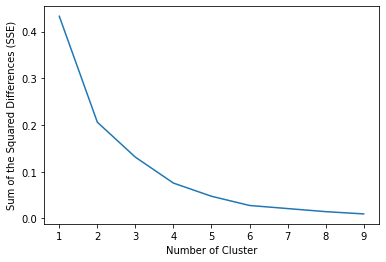

array([0, 3, 0, 0, 3, 0, 0, 0, 3, 0, 0, 0, 0, 7, 0, 0, 0, 0, 2, 0, 0, 0,
       0, 3, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 3, 0, 0, 3, 1, 0, 5, 3, 3, 6,
       8, 4, 0, 0, 0, 0, 0, 0, 0, 8, 0, 8], dtype=int32)

In [23]:
# CLustering
#Finding the best cluster numbers in terms of minimum error
sse={}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=0, max_iter=300).fit(SD_grouped_venues)
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of Cluster")
plt.ylabel("Sum of the Squared Differences (SSE)")
plt.show()
 
# Cluster labels generated for each row in the dataframe 
kmeans.labels_ 


Based on the above plot and elbow method, it seems that 7 clusters between 5 and 10 are the optimum. So we chose 7.

In [24]:
n_clusters=3
kmeans = KMeans(n_clusters, random_state=0, max_iter=300).fit(SD_grouped_venues)
 # Cluster labels generated for each row in the dataframe 
kmeans.labels_ 

array([2, 0, 2, 2, 0, 2, 2, 2, 0, 2, 2, 2, 2, 0, 2, 2, 2, 2, 0, 2, 2, 2,
       2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 0, 1, 2, 2, 0, 0, 0,
       2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int32)

In [25]:
# Adding cluster labels 
SD_grouped.insert(0,'Cluster Labels', kmeans.labels_)


In [26]:
# Making neighborhood as the first column
first_col1 = SD_grouped.pop("Neighborhood")
SD_grouped.insert(0, 'Neighborhood', first_col1)
SD_grouped.head()

,Neighborhood,Cluster Labels,Bagel Shop,Bakery,Breakfast Spot,Cafeteria,Café,Gaming Cafe,Coffee Shop
0,*SAN DIEGO,2,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000
1,"*SD, (ASW Training Center)",0,0.000000,0.0,0.0,0.035714,0.000000,0.0,0.071429
2,"*SD, (Naval Amphibious Base)",2,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000
3,"*SD, (Naval Hospital)",2,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000
4,"*SD, (Naval Supply Center)",0,0.014286,0.0,0.0,0.000000,0.014286,0.0,0.085714


In [27]:
#Adding cluster labels to San Diego dataframe
SD_df_final_labels=pd.merge(SD_df_final, SD_grouped, on='Neighborhood')
SD_df_final_labels

,ZIP CODE,Neighborhood,Location,Latitude,Longitude,Cluster Labels,Bagel Shop,Bakery,Breakfast Spot,Cafeteria,Café,Gaming Cafe,Coffee Shop
0,91902,BONITA,SOUTH,32.665762,-117.018657,2,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000
1,91910,CHULA VISTA,SOUTH,32.637868,-117.058031,2,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000
2,91911,CHULA VISTA,SOUTH,32.608185,-117.054512,2,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000
3,91913,CHULA VISTA,SOUTH,32.619459,-116.985820,2,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000
4,91914,CHULA VISTA,SOUTH,32.674004,-116.943932,2,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,92139,"SD, PARADISE HILLS",CENTRAL,32.679888,-117.048890,2,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000
71,92140,*SAN DIEGO,CENTRAL,32.739496,-117.197401,2,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000
72,92147,"*SD, (ASW Training Center)",CENTRAL,32.724880,-117.219962,0,0.0,0.0,0.000000,0.035714,0.0,0.0,0.071429
73,92155,"*SD, (Naval Amphibious Base)",SOUTH,32.674984,-117.161726,2,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000


***5.2 Visualization of clusters on San Diego Map***

In [28]:
n_clusters=3
map_SD_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)
# set color scheme for the clusters
x = np.arange(n_clusters)
ys = [i + x + (i*x)**2 for i in range(n_clusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(SD_df_final_labels['Latitude'], SD_df_final_labels['Longitude'], SD_df_final_labels['Neighborhood'], SD_df_final_labels['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-0],
        fill=True,
        fill_color=rainbow[cluster-0],
        fill_opacity=0.7).add_to(map_SD_clusters)
       
map_SD_clusters

In [29]:
SD_df_final_labels.loc[SD_df_final_labels['Cluster Labels'] == 0, SD_df_final_labels.columns[[1] + list(range(5, SD_df_final_labels.shape[1]))]]

,Neighborhood,Cluster Labels,Bagel Shop,Bakery,Breakfast Spot,Cafeteria,Café,Gaming Cafe,Coffee Shop
16,CARLSBAD,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.076923
17,CARLSBAD,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.076923
18,CARLSBAD,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.076923
19,CARLSBAD,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.076923
24,ENCINITAS,0,0.000000,0.000000,0.064516,0.000000,0.000000,0.000000,0.064516
30,LA JOLLA,0,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000,0.000000
31,"OCEANSIDE, CAMP PNDLTN",0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.066667
43,"SD, DOWNTOWN",0,0.000000,0.010000,0.020000,0.000000,0.030000,0.000000,0.070000
45,"SD, HILLCREST",0,0.000000,0.028571,0.000000,0.000000,0.000000,0.000000,0.114286
46,"SD, NORTH PARK",0,0.000000,0.000000,0.029412,0.000000,0.088235,0.000000,0.058824


In [30]:
SD_df_final_labels.loc[SD_df_final_labels['Cluster Labels'] == 1, SD_df_final_labels.columns[[1] + list(range(5, SD_df_final_labels.shape[1]))]]

,Neighborhood,Cluster Labels,Bagel Shop,Bakery,Breakfast Spot,Cafeteria,Café,Gaming Cafe,Coffee Shop
52,"SD, LINDA VISTA",1,0.0,0.0,0.0,0.0,0.0,0.0,0.5


In [31]:
SD_df_final_labels.loc[SD_df_final_labels['Cluster Labels'] == 2, SD_df_final_labels.columns[[1] + list(range(5, SD_df_final_labels.shape[1]))]]

,Neighborhood,Cluster Labels,Bagel Shop,Bakery,Breakfast Spot,Cafeteria,Café,Gaming Cafe,Coffee Shop
0,BONITA,2,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000
1,CHULA VISTA,2,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000
2,CHULA VISTA,2,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000
3,CHULA VISTA,2,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000
4,CHULA VISTA,2,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000
5,CHULA VISTA,2,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000
6,GUATAY (POB),2,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000
7,IMPERIAL BEACH,2,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000
8,LA MESA,2,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000
9,LA MESA,2,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000


#### **6. CONCLUSION**
In this project, we clustered San Diego neighborhoods based on the distribution of venues who serves coffee such as bagel shops, coffee shops, etc. to determine where would be the best neighborhood to open a new coffee shop. It is noted that this report has not taken into account the ratings of venues and the real estate costs in different neighborhoods, city permits and if any business can open in that neighborhood. Based on the optimization process, three clusters were generated. Based on the clustering model, we determined that neighborhoods in cluster 2 are the best options top open a new coffee shop as there are some areas that there is absolutely no coffee-related business.
In our report, we just frame our decision based on the number of similar businesses in a specific neighborhood. For future, we need a detailed data, on rating of businesses, city permits, real estate costs and other parameter that optimize the decision making process to provide a thorough analysis to the targeted customer.
